# Implementing ANNs with Tensorflow
## Homework 5 - 3/12/17
#### Auss Abbood, John Berroa, Luke Effenberger

# Section 2
Lukas' book code:

In [1]:
import numpy as np
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import os
import tensorflow as tf

class Book:
    def __init__(self, file):
        with open(file) as fd:
            book = fd.read()
            book = book.lower()
            tokenizer = RegexpTokenizer(r'\w+')
            book = tokenizer.tokenize(book)
            
        print("Unique words: " + str(len(Counter(book))))
        self._book_text = book
        
    
    def create_dictionaries(self, vocabulary_size):
        words_and_count = Counter(self._book_text).most_common(vocabulary_size - 1)
        
        word2id = {word: word_id for word_id, (word, _) in enumerate(words_and_count, 1)}
        word2id["UNKNOWN"] = 0
        
        id2word = dict(zip(word2id.values(), word2id.keys()))
        
        # Map words to ids
        self._book = [word2id.get(word, 0) for word in self._book_text]
        
        self._word2id = word2id
        self._id2word = id2word
    
    
    def words2ids(self, words):
        if type(words) == list or type(words) == range or type(words) == np.ndarray:
            return [self._word2id.get(word, 0) for word in words]
        else:
            return self._word2id.get(words, 0)
            
    def ids2words(self, ids):
        if type(ids) == list or type(ids) == range or type(ids) == np.ndarray:
            return [self._id2word.get(wordid, "UNKNOWN") for wordid in ids]
        else:
            return self._id2word.get(ids, 0)
    
    
    def get_training_batch(self, batch_size, skip_window):        
        valid_indices = range(skip_window, len(self._book) - (skip_window + 1))
        context_range = [x for x in range(-skip_window, skip_window + 1) if x != 0]
        wordid_contextid_pairs = [(word_id, word_id + shift) for word_id in valid_indices for shift in context_range]
        
        np.random.shuffle(wordid_contextid_pairs)
        
        counter = 0
        words = np.zeros((batch_size), dtype = np.int32)
        contexts = np.zeros((batch_size, 1), dtype = np.int32)
        
        for word_index, context_index in wordid_contextid_pairs:
            words[counter] = self._book[word_index]
            contexts[counter, 0] = self._book[context_index]
            counter += 1
            
            if counter == batch_size:
                yield words, contexts
                counter = 0
                


# Sections 2, 3, and 4
We are going to explore the data by creating a small dictionary and playing around with the functionality including in Lukas' book class...

In [2]:
bible_data = Book("bible.txt")

Unique words: 13083


In [3]:
bible_dict = bible_data.create_dictionaries(100)

Let's test a funny sentence!

In [4]:
test_words = ['and','they','were', 'both', 'naked']
print("WORDS: {}".format(test_words))
test_ids = bible_data.words2ids(test_words)
print("IDS: {}".format(test_ids))
re_words = bible_data.ids2words(test_ids)
print("RE_WORDS: {}".format(re_words))

WORDS: ['and', 'they', 'were', 'both', 'naked']
IDS: [2, 15, 45, 0, 0]
RE_WORDS: ['and', 'they', 'were', 'UNKNOWN', 'UNKNOWN']


With a dictionary of only 100 words, the bible doesn't not mention "both" or "naked". Thus, they are UNKNOWN.

In [5]:
# Test what comes out of the training batches
test_generator = bible_data.get_training_batch(8,2)
for i,(words, context) in enumerate(test_generator):
    if i==0:
        print(words)
        print(context)

[48 30 80  7  2 29  0 41]
[[ 0]
 [ 0]
 [ 0]
 [ 2]
 [ 0]
 [ 0]
 [10]
 [ 0]]


# Section 5

In [6]:
# Hyperparameters per the homework
batch_size = 128
epochs = 20
learning_rate = 1
vocabulary_size = 10000
embedding_size = 64
skip_window = 2
noise_samples_n = 65
# Number of most similar words for validation
k = 8

# Create the dictionary
bible_data.create_dictionaries(vocabulary_size)

# Section 6
Now let's make the Tensorflow word embedding graph.  We will also use Tensorboard for graphs, because that makes life easier.  Feel free to load it up!

In [7]:
# Reset the default graph to avoid variable initializing conflicts
tf.reset_default_graph()

# Placeholders for the words as input and the context as the corresponding label
word_ids = tf.placeholder(tf.int32, [None])
train_labels = tf.placeholder(tf.int32,[None,1])

# Node for the embeddings of the words
with tf.variable_scope("embedding"):
    # Initializer for embeddings
    initializer = tf.random_uniform_initializer(-1.0, 1.0)
    
    embeddings = tf.get_variable("embedding", [vocabulary_size, embedding_size], initializer=initializer)
    embed = tf.nn.embedding_lookup(embeddings, word_ids)
    
#N ode fpr the nce-loss
with tf.variable_scope("nce_loss"):
    # Initializer for nce-weights
    initializer = tf.truncated_normal_initializer(stddev = 1.0 / np.sqrt(embedding_size))
    
    nce_weights = tf.get_variable("weights", [vocabulary_size, embedding_size], tf.float32, initializer)
    nce_biases = tf.get_variable("biases", [vocabulary_size], initializer = tf.zeros_initializer())
    
    nce_loss = tf.nn.nce_loss(
        weights = nce_weights,
        biases = nce_biases,
        labels = train_labels,
        inputs = embed,
        num_sampled = noise_samples_n,
        num_classes = vocabulary_size
    )
    nce_loss = tf.reduce_mean(nce_loss)
    
    tf.summary.scalar("nce_loss", nce_loss)
    
    
# Node for the optimizer
with tf.variable_scope("optimizer"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_step = optimizer.minimize(nce_loss)
    
merged_summaries = tf.summary.merge_all()

In [8]:
# Validation testing code
ids_val= tf.placeholder(tf.int32, [None])
embed_val = tf.nn.embedding_lookup(embeddings, ids_val)

normed_embeddings = tf.nn.l2_normalize(embeddings, dim=1)
normed_embed_val = tf.nn.l2_normalize(embed_val, dim=1)

cosine_sim = tf.matmul(normed_embed_val, tf.transpose(normed_embeddings, [1, 0]))


closest_words_ids = tf.nn.top_k(cosine_sim,k=k)




# Function to print the most similar words
# For reference, closest_words.shape=[batch_size,number_of_words]
def print_closest_words(words_val,closest_words_ids):
    for i,sim_words_ids in enumerate(closest_words_ids):
        sim_words = bible_data.ids2words(sim_words_ids)
        print(words_val[i] + ': ' + ', '.join(sim_words[1:]))

# Section 7 and 8
Now we train the network.  Open Tensorboard now!

In [9]:
train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())

# Words for validation as per the homework
print("Validation before Epoch 0")
words_val = ['5', 'make', 'god', 'jesus', 'year', 'sin', 'israel', 'cross']
ids_val_inp = np.array(bible_data.words2ids(words_val))

with tf.Session() as sess:
    step = 0
    sess.run(tf.global_variables_initializer())
    
    # First validation before training with cosine so that we see where everything initializes
    _closest_words_ids = sess.run([closest_words_ids], feed_dict={ids_val:ids_val_inp})
    print_closest_words(words_val,_closest_words_ids[0][1])
    
    
    for epoch in range(epochs):

        batch_generator = bible_data.get_training_batch(batch_size,skip_window)
        
        for i, (words, contexts) in enumerate(batch_generator):
            _summaries, _ = sess.run([merged_summaries, training_step],
                                feed_dict={word_ids:words,
                                          train_labels:contexts})
            
            train_writer.add_summary(_summaries, step)    
        
            step += 1
            
        # Validation after each epoch (called "steps")
        print("\n" + "Validation Epoch {}".format(epoch))
        _closest_words_ids = sess.run([closest_words_ids], feed_dict={ids_val:ids_val_inp})
        print_closest_words(words_val,_closest_words_ids[0][1])
        
    
    # After training get the embeddings
    embeddings_arr = embeddings.eval()

Validation before Epoch 0
5: trouble, spices, using, uproar, following, flags, perfected
make: blasphemously, yield, atonement, dishonour, roofs, carry, teach
god: sinew, lived, nebuzaradan, eightieth, teman, jetur, besor
jesus: travailed, laded, judgments, joel, separate, golan, path
year: poured, furthermore, kedemah, prospect, fourfold, admah, moloch
sin: phut, hod, golan, azareel, suah, sophereth, manifold
israel: federal, moabite, journeys, anathema, fuel, securely, twain
cross: milk, partly, obey, surety, 121, winefat, throat

Validation Epoch 0
5: 2, 19, 3, 4, 1, 11, 10
make: teach, yield, defend, atonement, incorruption, anoint, sayest
god: lord, sinful, condemn, sign, repent, glory, also
jesus: he, bruising, she, knops, worldly, beholding, path
year: hot, tyre, month, magdalene, ringstraked, borne, poured
sin: therewith, husbands, cloud, golan, stead, died, acquaintance
israel: beset, journeys, federal, jeroham, boast, smell, the
cross: milk, obey, partly, gibeah, sown, surety

Interesting!  After 9 epochs or so, there isn't much change.  The numbers definitely found their cluster.

We now save the embeddings, and reload them so that we can test them now, and also at a later date.

In [15]:
np.save('./embbedings.npy',embeddings_arr)

In [ ]:
# Reload numpy array
embbedings_arr = np.load('./embeddings.npy')
print(embeddings_arr.shape)

In [17]:
# Visualizing the embeddings of the first n words in a 2d map with t-sne

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook

# HYPERPARAMTERS for tsne
start_n = 0
n = 100 # how many words to visualize
prp = 7 # perplexity rate

# Get the data for the visualization
ids = np.arange(start_n,start_n+n)
words = bible_data.ids2words(ids)

# Section 10
Now let's make the T-SNE plot.

(100, 2)


<IPython.core.display.Javascript object>


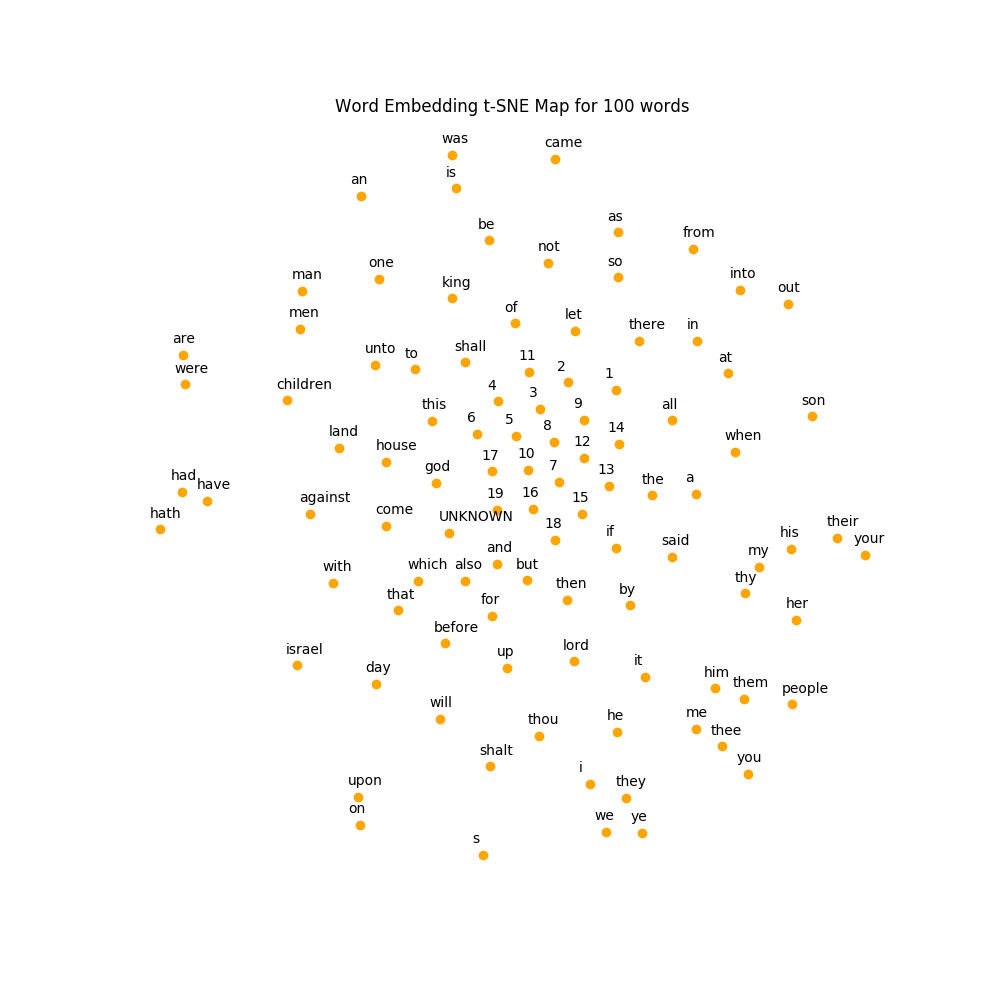

In [29]:
tsne = TSNE(perplexity=25, n_components=2, init='pca',
           n_iter_without_progress=500, method='exact')
embeddings_2d = tsne.fit_transform(embeddings_arr[start_n:start_n+n,:])
print(embeddings_2d.shape)


# Plotting
fig = plt.figure(figsize=(10,10))
plt.scatter(embeddings_2d[:,0],embeddings_2d[:,1],c='orange')
plt.axis('off')
plt.title("Word Embedding t-SNE Map for {} words".format(n))
for i in range(n):
    xi = embeddings_2d[i,0]
    yi = embeddings_2d[i,1]
    plt.annotate(words[i], xy=(xi,yi), xytext=(xi-3,yi+3))
plt.show()



# Section 11
We will now attempt analogical reasoning.  The idea behind this is we have two vectors, subtract them, and get a new word that is somehow related to the semantic "math" that we just did.

To do this, we will try 3 pairs of words:

* jesus - man + holy = ?
* fire - bush + house = ?
* jerusalem - people + city = ?

In [ ]:
originals = ['jesus', 'fire', 'jerasulem']
minuses = ['man', 'bush', 'people']
plusses = ['holy, house, city']

# Transfrom into numbers:
originals_id = bible_data.words2ids(originals)
minuses_id = bible_data.words2ids(minuses)
plusses_id = bible_data.words2ids(plusses)

embedded_semantics = []
wurds = [originals_id, minuses_id, plusses_id]
# Create vectors
with tf.Session() as sess:
    for words in range(3):
        embedded_semantics.append(sess.run([embed], feed_dict={ids_val: wurds[words]}))
    
normed_emb_sem = []
for i in range(3):
    normed_emb_sem.append(tf.nn.l2_normalize(embedded_semantics[i]))    
    
first_try = normed_emb_sem[0][0] - normed_emb_sem[0][1] + normed_emb_sem[0][2]
second_try = normed_emb_sem[1][0] - normed_emb_sem[1][1] + normed_emb_sem[1][2]
thirds_try = normed_emb_sem[2][0] - normed_emb_sem[2][1] + normed_emb_sem[2][2]

cosine_similarity_one = tf.matmul(first_try, tf.transpose(normed_embeddings, [1, 0]))
cosine_similarity_second = tf.matmul(second_try, tf.transpose(normed_embeddings, [1, 0]))
cosine_similarity_third = tf.matmul(third_try, tf.transpose(normed_embeddings, [1, 0]))

nn_try1 = tf.nn.top_k(cosine_similarity_one, 6)
nn_try2 = tf.nn.top_k(cosine_similarity_second, 6)
nn_try3 = tf.nn.top_k(cosine_similarity_third, 6)

tries = [nn_try1, nn_try2, nn_try3]
with tf.Session() as sess:
    for i in range(3):
        out = tf.Session.run(tries[i], feed_dict={ids_val: wurds[i]})
        print("For the analogical reasoning: {}-{}+{}, the top 5 nearest are:{}".format(originals[i], minuses[i], plusses[i], tries[i]))


